# NDIndex Slicing Gallery

This notebook provides visual examples of how NDIndex slicing works using images.
By wrapping an image in an xarray DataArray with 2D coordinates, we can see
exactly what regions are selected by different slice operations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cbook

from linked_indices import NDIndex
from linked_indices.viz import visualize_slice_selection, visualize_radial_selection

## Setup: Load an image and create 2D coordinates

We'll use matplotlib's sample image and create a 2D coordinate system where
the coordinate values vary non-uniformly across the image.

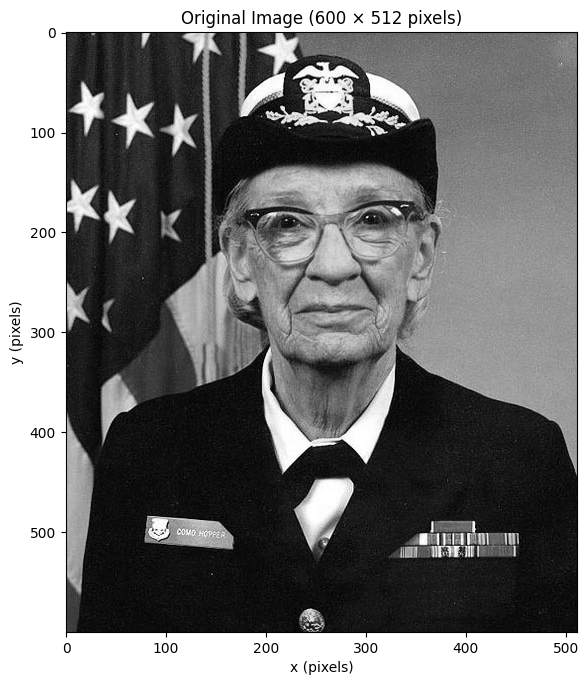

In [2]:
# Load matplotlib sample image
with cbook.get_sample_data("grace_hopper.jpg") as image_file:
    gray = plt.imread(image_file).mean(axis=2)  # converting to grayscale for simplicity


fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(gray, cmap="gray")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title(f"Original Image ({gray.shape[0]} × {gray.shape[1]} pixels)")
plt.tight_layout()

## Create a 2D coordinate with unique values

Let's create a 2D coordinate where each cell has a **unique** value.
We use `derived = y * nx + x` which is equivalent to the flat index.
This ensures scalar selection returns exactly one cell.

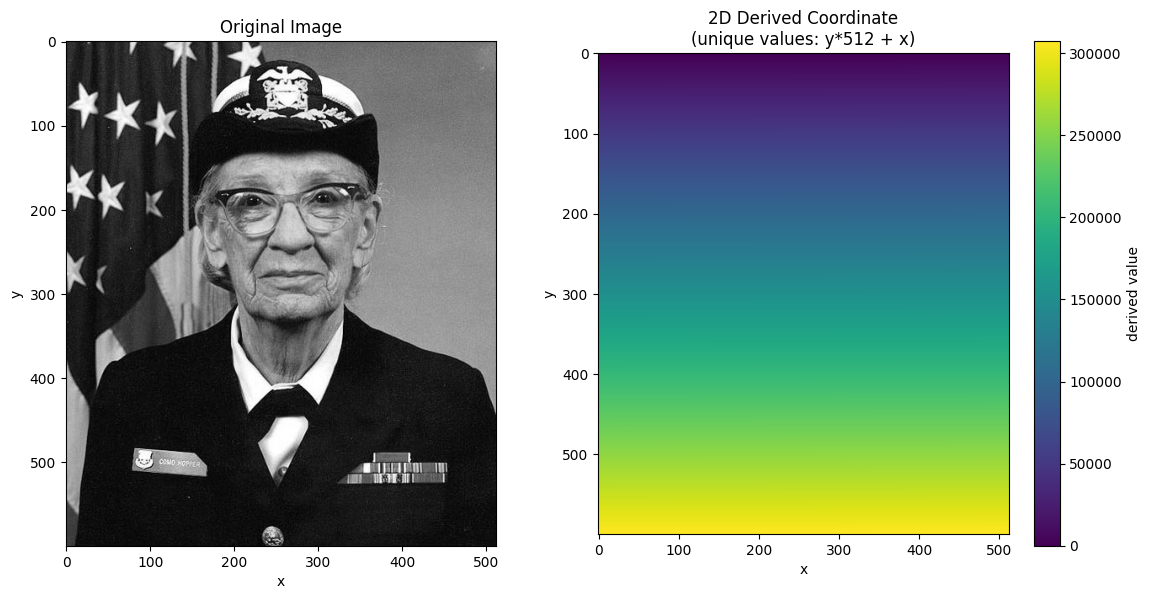

In [3]:
ny, nx = gray.shape

# Create 1D coordinates
y_coord = np.arange(ny)
x_coord = np.arange(nx)

# Create a 2D "derived" coordinate with UNIQUE values
# derived[y, x] = y * nx + x (like flat index)
# This ensures every cell has a distinct value
derived_coord = y_coord[:, np.newaxis] * nx + x_coord[np.newaxis, :]

# Visualize the derived coordinate
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(gray, cmap="gray")
ax.set_title("Original Image")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
im = ax.imshow(derived_coord, cmap="viridis")
ax.set_title("2D Derived Coordinate\n(unique values: y*512 + x)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="derived value")

plt.tight_layout()

## Create xarray DataArray with NDIndex

Now we wrap the image in an xarray DataArray and attach the 2D coordinate with NDIndex.

In [4]:
# Create DataArray
da = xr.DataArray(
    gray,
    dims=["y", "x"],
    coords={
        "y": y_coord,
        "x": x_coord,
        "derived": (["y", "x"], derived_coord),
    },
    name="image",
)

# Apply NDIndex to the 2D derived coordinate
da_indexed = da.set_xindex(["derived"], NDIndex)
da_indexed

<xarray.DataArray 'image' (y: 600, x: 512)> Size: 2MB
array([[ 40.66666667,  47.33333333,  53.33333333, ..., 126.33333333,
        121.33333333, 126.33333333],
       [ 45.66666667,  45.33333333,  47.33333333, ..., 110.33333333,
        106.33333333, 112.33333333],
       [ 40.66666667,  40.33333333,  40.33333333, ..., 128.66666667,
        129.66666667, 137.66666667],
       ...,
       [ 63.66666667,  70.33333333,  70.33333333, ...,  15.33333333,
         14.33333333,  12.33333333],
       [ 61.33333333,  65.33333333,  67.        , ...,  14.33333333,
         14.33333333,  13.33333333],
       [ 62.33333333,  64.33333333,  65.66666667, ...,  15.33333333,
         15.33333333,  15.33333333]], shape=(600, 512))
Coordinates:
  * y        (y) int64 5kB 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
  * x        (x) int64 4kB 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
  * derived  (y, x) int64 2MB 0 1 2 3 4 5 ... 307195 307196 307197 307198 307199
Indexes:
    derived  NDIndex

## Scalar Selection

Selecting a single value finds the cell with the value closest to the target.
With unique values, the result is unambiguous - exactly one cell is returned.

In [5]:
# Select the cell at the center of the image
center_y, center_x = ny // 2, nx // 2
center_value = derived_coord[center_y, center_x]

print(f"Center of image: y={center_y}, x={center_x}")
print(f"Derived value at center: {center_value}")

result = da_indexed.sel(derived=center_value, method="nearest")
print(f"Selection result: y={result.y.item()}, x={result.x.item()}")
result

Center of image: y=300, x=256
Derived value at center: 153856
Selection result: y=300, x=256


<xarray.DataArray 'image' (y: 1, x: 1)> Size: 8B
array([[151.66666667]])
Coordinates:
  * y        (y) int64 8B 300
  * x        (x) int64 8B 256
  * derived  (y, x) int64 8B 153856
Indexes:
    derived  NDIndex

In [6]:
# Select the cell at the center of the image
center_y, center_x = ny // 2, nx // 2
center_value = derived_coord[center_y, center_x]

result = da_indexed.sel(derived=center_value, method="nearest")
result

<xarray.DataArray 'image' (y: 1, x: 1)> Size: 8B
array([[151.66666667]])
Coordinates:
  * y        (y) int64 8B 300
  * x        (x) int64 8B 256
  * derived  (y, x) int64 8B 153856
Indexes:
    derived  NDIndex

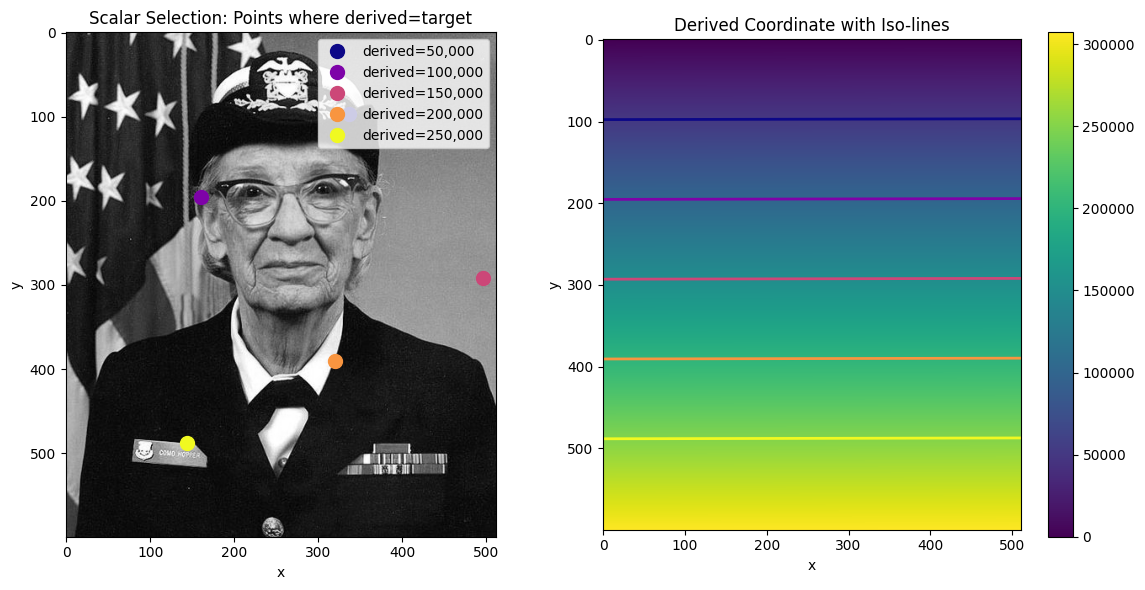

In [7]:
# Visualize scalar selections at different values
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show image with selected points
ax = axes[0]
ax.imshow(gray, cmap="gray")

# Use values that span the coordinate range (0 to ~307,000)
targets = [50000, 100000, 150000, 200000, 250000]
colors = plt.cm.plasma(np.linspace(0, 1, len(targets)))

for target, color in zip(targets, colors):
    result = da_indexed.sel(derived=target, method="nearest")
    ax.plot(
        result.x.item(),
        result.y.item(),
        "o",
        color=color,
        markersize=10,
        label=f"derived={target:,}",
    )

ax.legend(loc="upper right")
ax.set_title("Scalar Selection: Points where derived=target")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Show derived coordinate with iso-lines
ax = axes[1]
im = ax.imshow(derived_coord, cmap="viridis")
# Draw contours for each target value with matching colors
for target, color in zip(targets, colors):
    ax.contour(derived_coord, levels=[target], colors=[color], linewidths=2)
ax.set_title("Derived Coordinate with Iso-lines")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax)

plt.tight_layout()

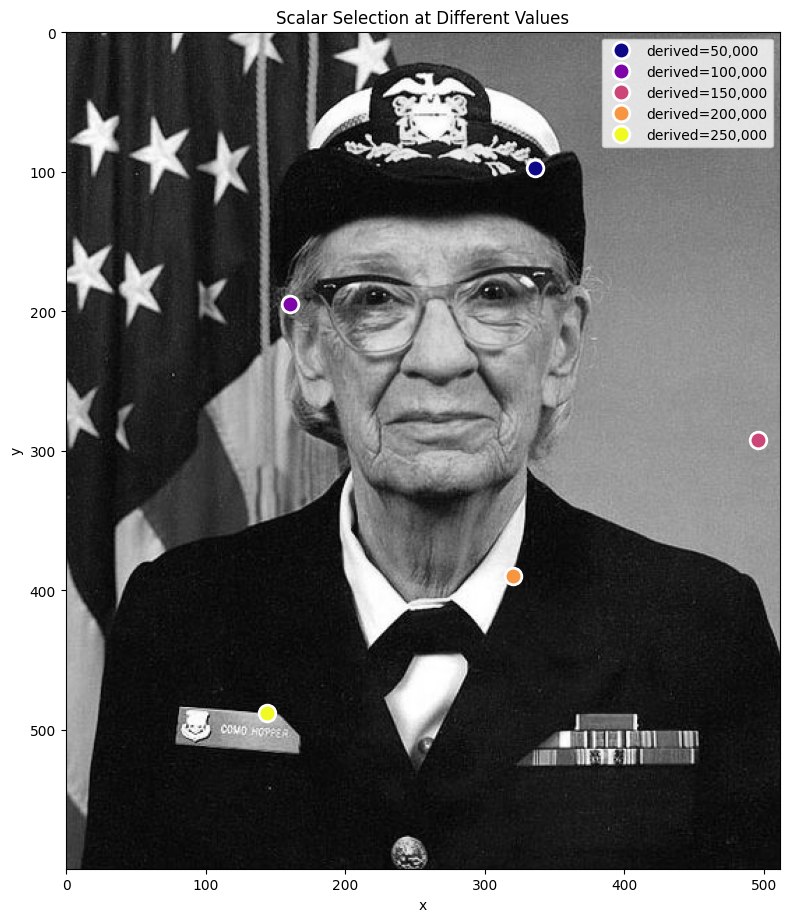

In [8]:
# Visualize scalar selections at different values
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(gray, cmap="gray")

# Use values that span the coordinate range (0 to ~307,000)
targets = [50000, 100000, 150000, 200000, 250000]
colors = plt.cm.plasma(np.linspace(0, 1, len(targets)))

for target, color in zip(targets, colors):
    result = da_indexed.sel(derived=target, method="nearest")
    ax.plot(
        result.x.item(),
        result.y.item(),
        "o",
        color=color,
        markersize=12,
        markeredgecolor="white",
        markeredgewidth=2,
        label=f"derived={target:,}",
    )

ax.legend(loc="upper right")
ax.set_title("Scalar Selection at Different Values")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()

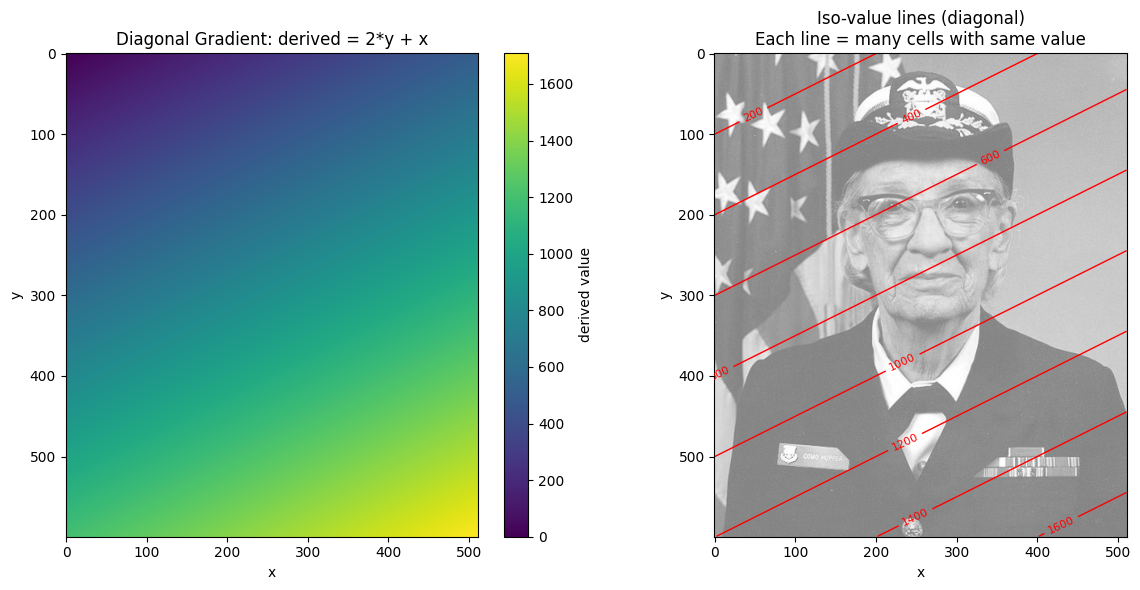

In [9]:
# Create a diagonal gradient with NON-UNIQUE values
# derived = 2*y + x means diagonal lines share the same value
diagonal_coord = y_coord[:, np.newaxis] * 2 + x_coord[np.newaxis, :]

# Visualize the diagonal coordinate and its duplicate structure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
im = ax.imshow(diagonal_coord, cmap="viridis")
ax.set_title("Diagonal Gradient: derived = 2*y + x")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="derived value")

# Show contour lines - these are the "iso-value" diagonals
ax = axes[1]
ax.imshow(gray, cmap="gray", alpha=0.5)
contours = ax.contour(diagonal_coord, levels=10, colors="red", linewidths=1)
ax.clabel(contours, inline=True, fontsize=8)
ax.set_title("Iso-value lines (diagonal)\nEach line = many cells with same value")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

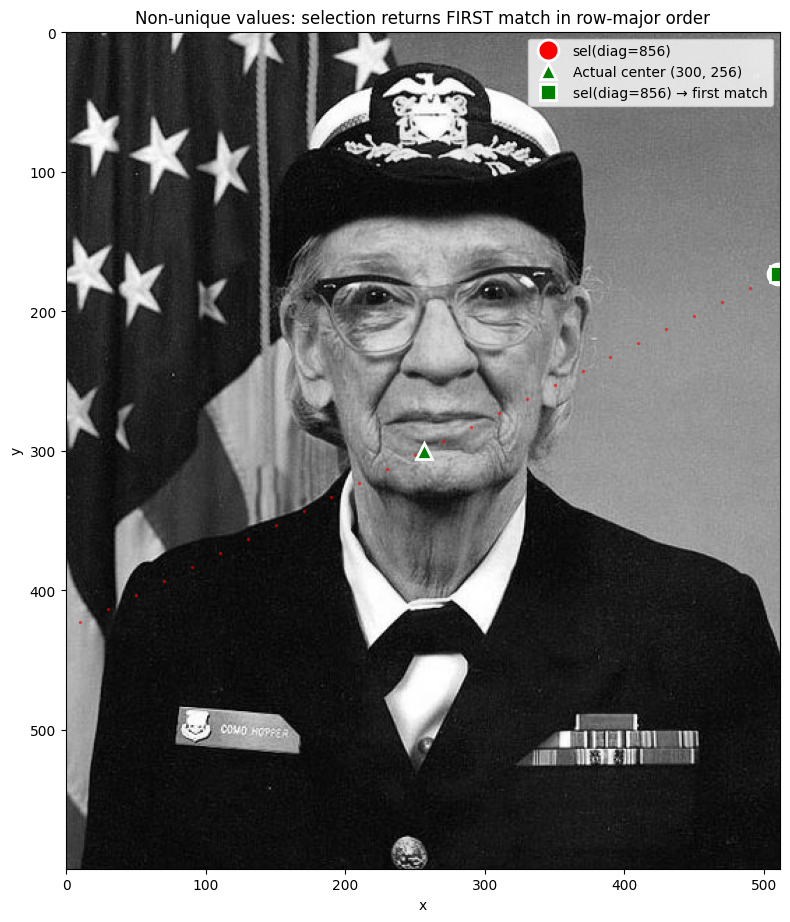

In [10]:
# Create DataArray with diagonal coordinate
da_diagonal = xr.DataArray(
    gray,
    dims=["y", "x"],
    coords={"y": y_coord, "x": x_coord, "diag": (["y", "x"], diagonal_coord)},
    name="image",
)
da_diagonal_indexed = da_diagonal.set_xindex(["diag"], NDIndex)

# Select by a value that has multiple matches
target_val = 856
result_diag = da_diagonal_indexed.sel(diag=target_val, method="nearest")

# Also try selecting the center's value
center_diag_val = diagonal_coord[300, 256]
result_center = da_diagonal_indexed.sel(diag=center_diag_val, method="nearest")

# Visualize: show where each selection lands
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(gray, cmap="gray")

# Mark all cells with target_val
matches = np.argwhere(diagonal_coord == target_val)
for y, x in matches[::10]:  # Plot every 10th to avoid clutter
    ax.plot(x, y, "r.", markersize=3, alpha=0.5)

# Mark the selected cell
ax.plot(
    result_diag.x.item(),
    result_diag.y.item(),
    "ro",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=2,
    label=f"sel(diag={target_val})",
)

# Mark center and where center's value selection lands
ax.plot(
    256,
    300,
    "g^",
    markersize=12,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Actual center (300, 256)",
)
ax.plot(
    result_center.x.item(),
    result_center.y.item(),
    "gs",
    markersize=12,
    markeredgecolor="white",
    markeredgewidth=2,
    label=f"sel(diag={center_diag_val}) → first match",
)

ax.legend(loc="upper right")
ax.set_title("Non-unique values: selection returns FIRST match in row-major order")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()

When multiple cells share the same coordinate value, `method='nearest'` returns the
**first match in row-major (C) order** — scanning left-to-right, top-to-bottom.

To select a specific cell among duplicates, use the dimension coordinates directly:

```python
da.sel(y=300, x=256)  # Specific cell
```

## Slice Selection: Bounding Box Behavior

When you select a range with `slice()`, NDIndex returns a **bounding box** - the smallest
rectangular region containing all cells with values in that range.

This is important: the bounding box may include cells **outside** your requested range!

In [11]:
# Select range: derived between 100000 and 150000
start, stop = 100000, 150000
result = da_indexed.sel(derived=slice(start, stop))

# Display the result - note how the bounding box includes values outside the range
result

<xarray.DataArray 'image' (y: 98, x: 512)> Size: 401kB
array([[ 47.66666667,  38.66666667,  35.66666667, ..., 141.33333333,
        136.33333333, 138.33333333],
       [ 45.        ,  43.        ,  39.        , ..., 148.33333333,
        142.33333333, 143.33333333],
       [ 32.        ,  36.        ,  32.33333333, ..., 148.33333333,
        146.33333333, 142.33333333],
       ...,
       [ 47.        ,  96.        , 146.        , ..., 150.66666667,
        152.66666667, 155.66666667],
       [ 45.        ,  89.        , 145.        , ..., 148.66666667,
        152.66666667, 157.66666667],
       [ 33.        ,  78.33333333, 139.33333333, ..., 146.66666667,
        150.66666667, 154.66666667]], shape=(98, 512))
Coordinates:
  * y        (y) int64 784B 195 196 197 198 199 200 ... 287 288 289 290 291 292
  * x        (x) int64 4kB 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
  * derived  (y, x) int64 401kB 99840 99841 99842 99843 ... 150013 150014 150015
Indexes:
    derived  NDIndex

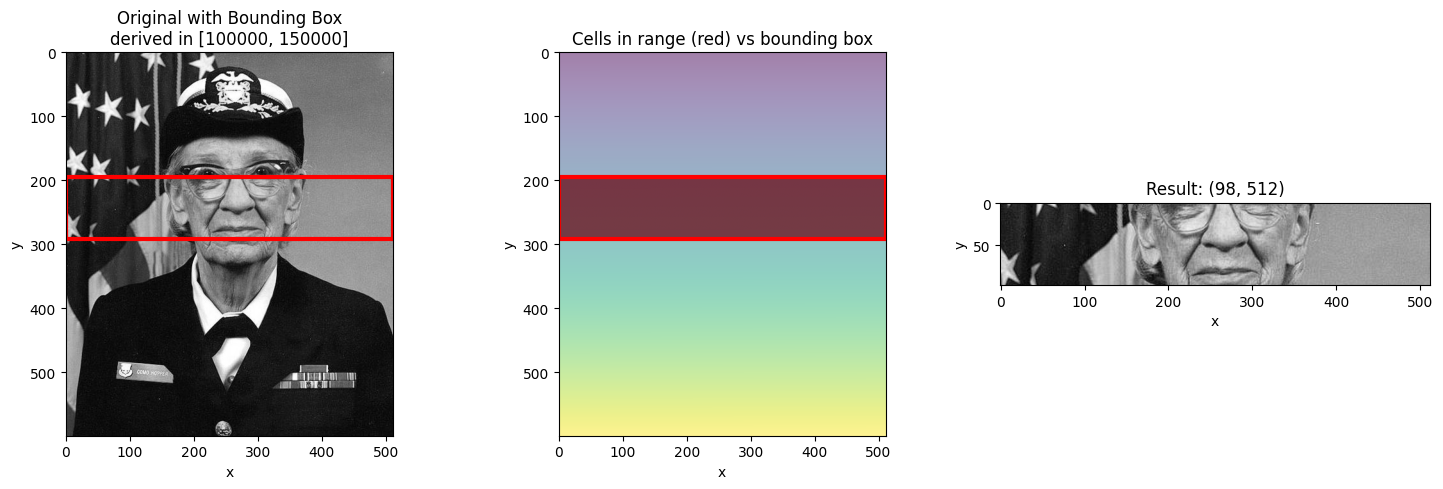

In [12]:
visualize_slice_selection(da_indexed, 100000, 150000);

## Different Slice Ranges

Let's see how different ranges produce different bounding boxes.

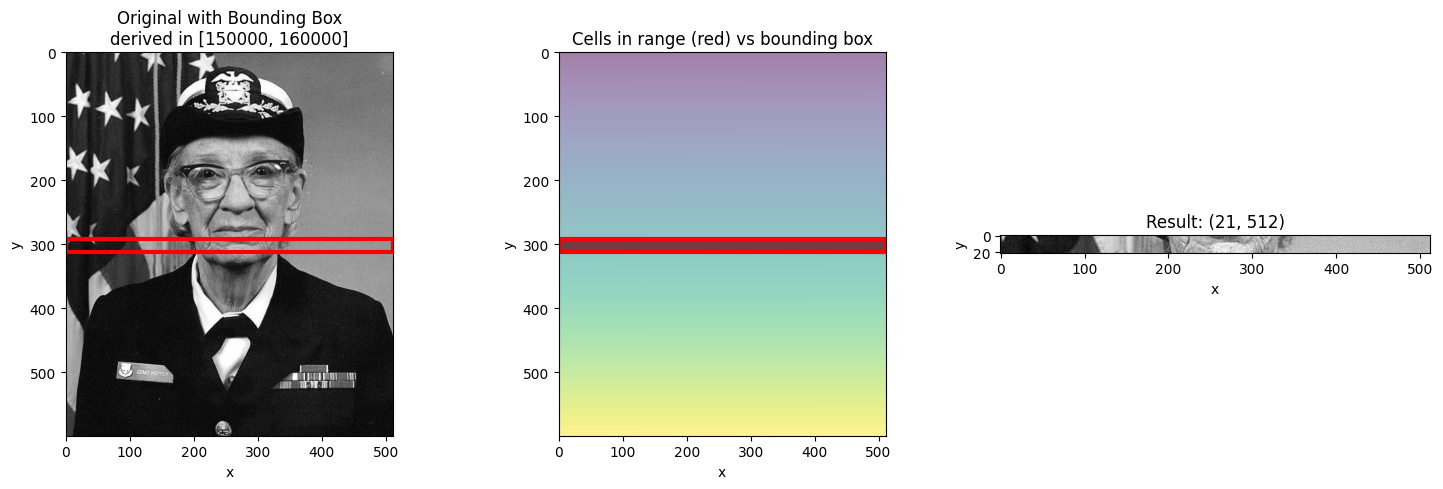

In [13]:
# Narrow range - smaller bounding box
visualize_slice_selection(da_indexed, 150000, 160000);

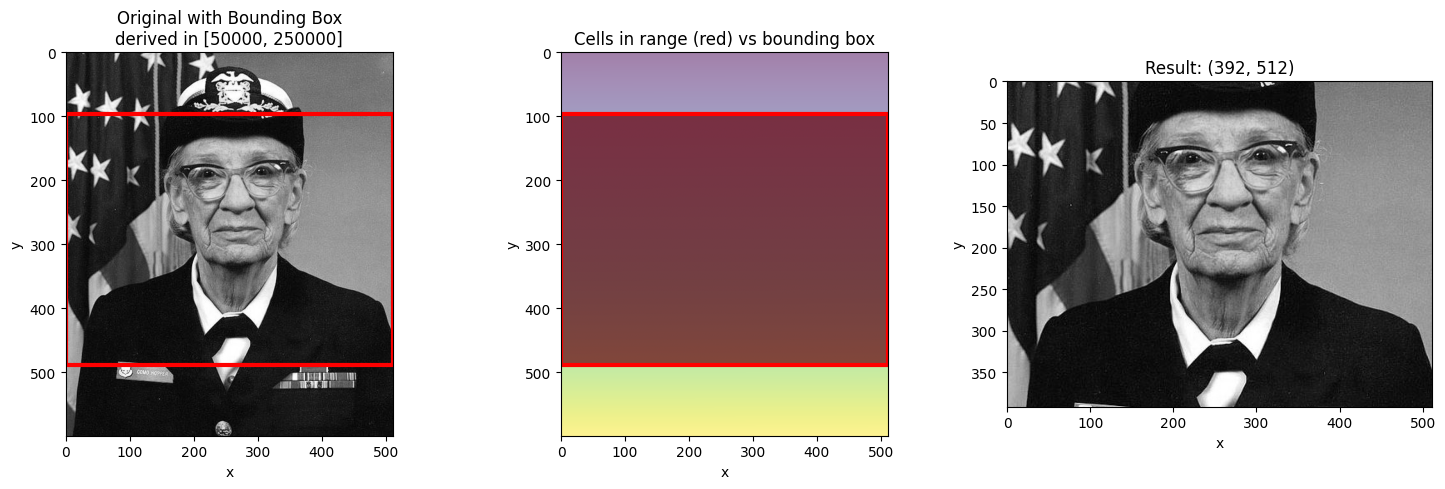

In [14]:
# Wide range - larger bounding box
visualize_slice_selection(da_indexed, 50000, 250000);

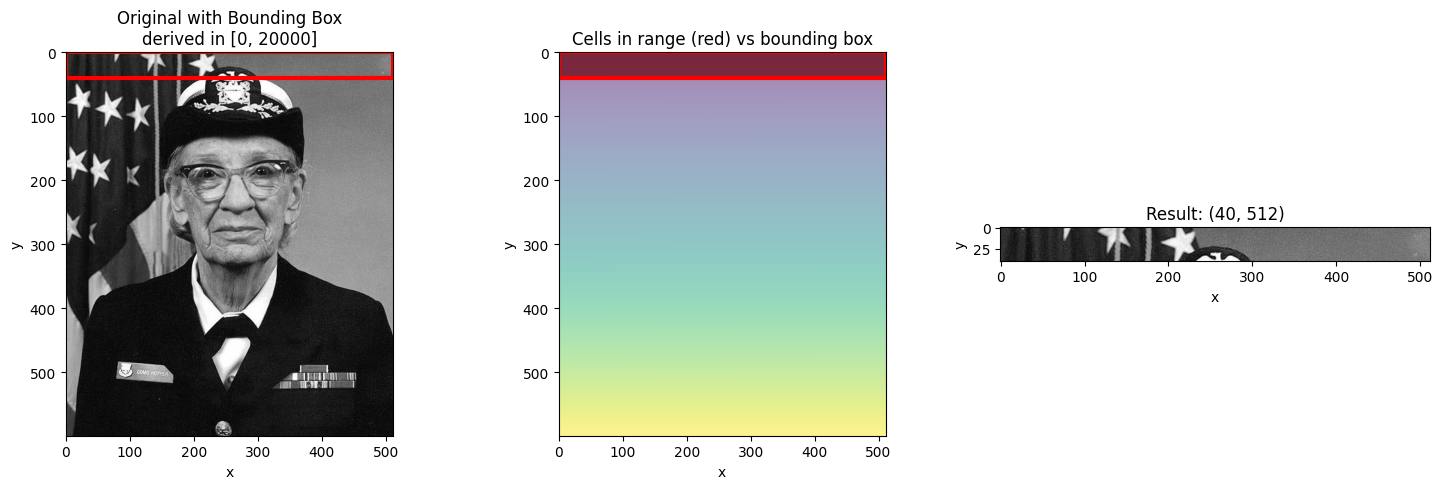

In [15]:
# Range at the edge
visualize_slice_selection(da_indexed, 0, 20000);

## Filtering with `.where()` after Selection

Since the bounding box includes cells outside your requested range, you may want to
filter the result using `.where()` to mask out values not in the range.

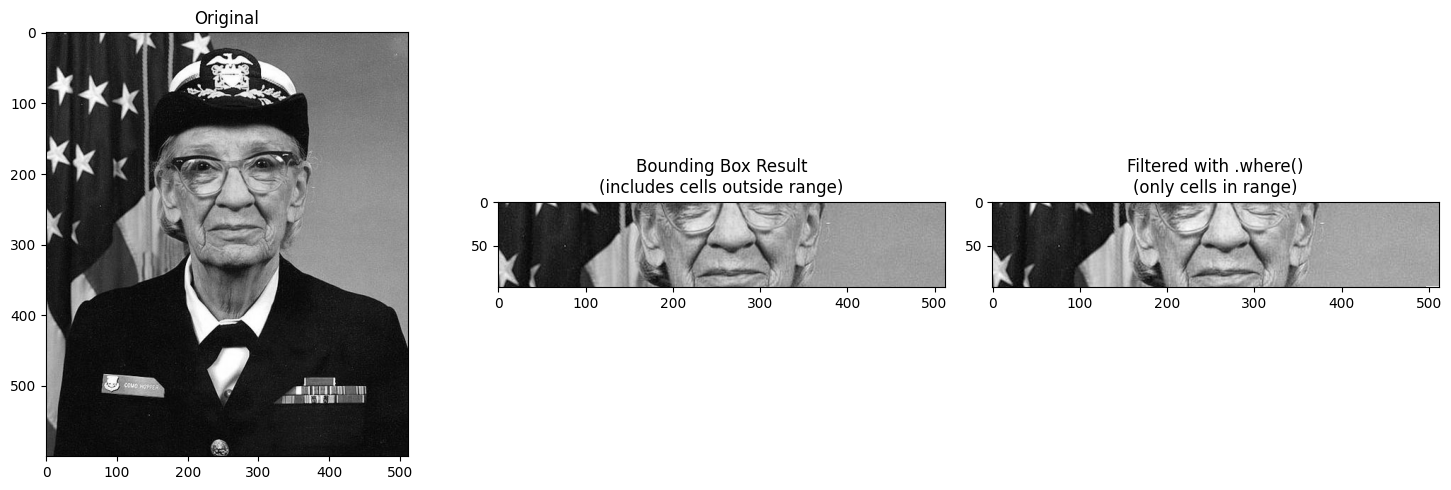

In [16]:
start, stop = 100000, 150000
result = da_indexed.sel(derived=slice(start, stop))

# Filter to only show cells actually in range
in_range = (result.derived >= start) & (result.derived <= stop)
filtered = result.where(in_range)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(da_indexed.values, cmap="gray")
ax.set_title("Original")

ax = axes[1]
ax.imshow(result.values, cmap="gray")
ax.set_title("Bounding Box Result\n(includes cells outside range)")

ax = axes[2]
ax.imshow(filtered.values, cmap="gray")
ax.set_title("Filtered with .where()\n(only cells in range)")

plt.tight_layout()

## Using Step in Slices

You can include a step in the slice to subsample the innermost dimension.

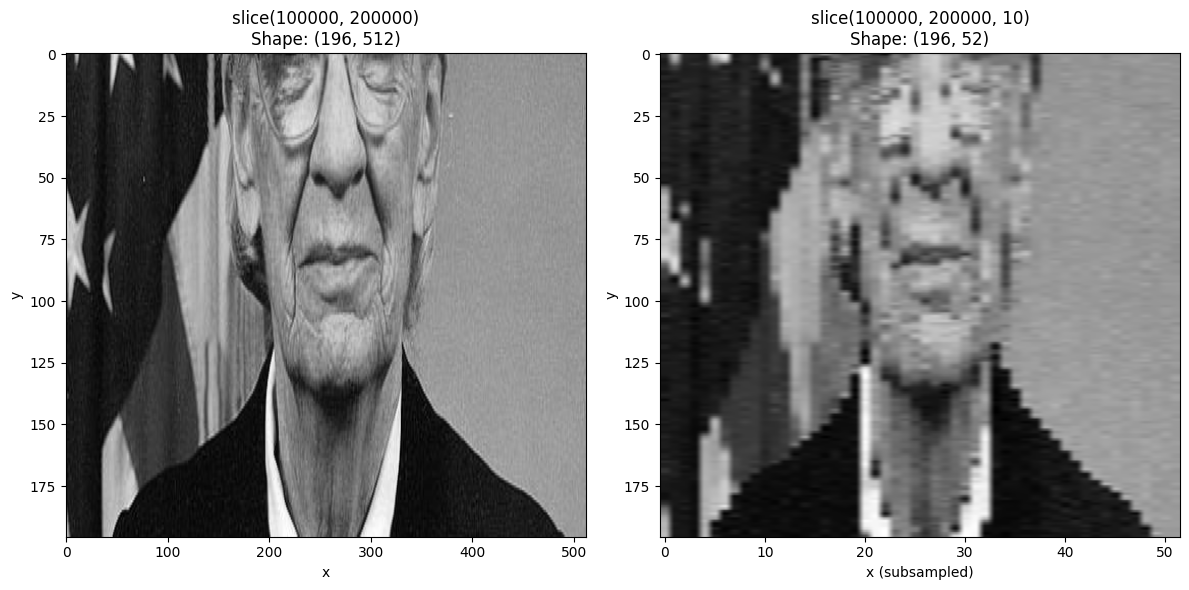

In [17]:
start, stop = 100000, 200000

# Without step
result_no_step = da_indexed.sel(derived=slice(start, stop))

# With step=10 (subsample every 10th pixel in x)
result_with_step = da_indexed.sel(derived=slice(start, stop, 10))

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(result_no_step.values, cmap="gray", aspect="auto")
ax.set_title(f"slice({start}, {stop})\nShape: {result_no_step.shape}")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(result_with_step.values, cmap="gray", aspect="auto")
ax.set_title(f"slice({start}, {stop}, 10)\nShape: {result_with_step.shape}")
ax.set_xlabel("x (subsampled)")
ax.set_ylabel("y")

plt.tight_layout()

## Non-Linear 2D Coordinates

The bounding box behavior becomes more interesting with non-linear coordinates.
Let's create a radial coordinate to see how this works.

In [18]:
# Create a radial coordinate centered on the image
cy, cx = ny // 2, nx // 2  # center
yy, xx = np.meshgrid(np.arange(ny) - cy, np.arange(nx) - cx, indexing="ij")
radial_coord = np.sqrt(xx**2 + yy**2)

# Create DataArray with radial coordinate
da_radial = xr.DataArray(
    gray,
    dims=["y", "x"],
    coords={
        "y": y_coord,
        "x": x_coord,
        "radius": (["y", "x"], radial_coord),
    },
    name="image",
)
da_radial_indexed = da_radial.set_xindex(["radius"], NDIndex)

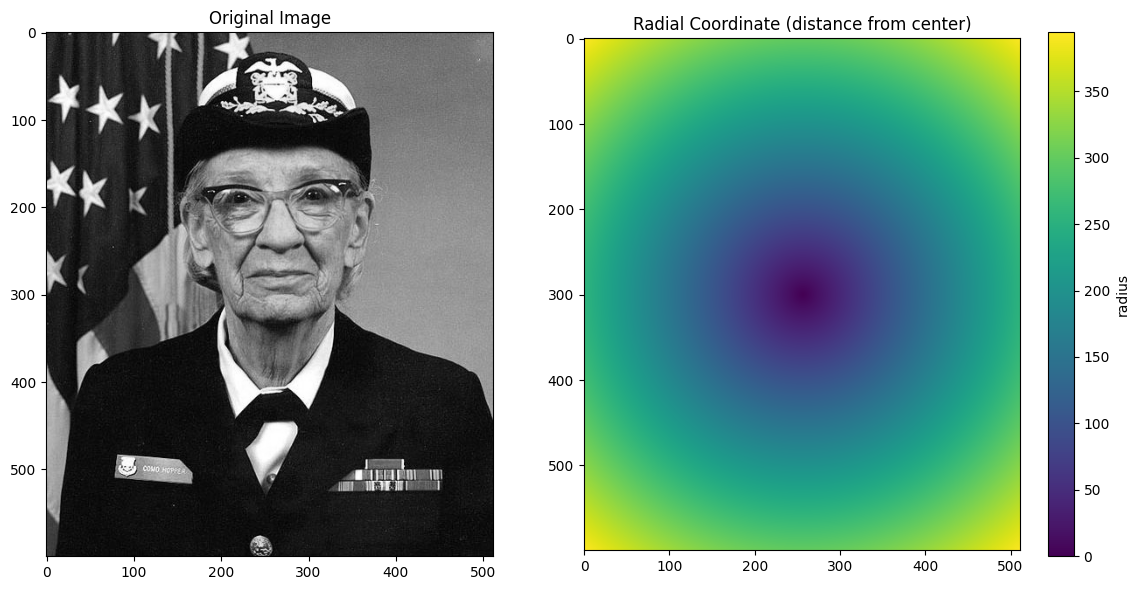

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(gray, cmap="gray")
ax.set_title("Original Image")

ax = axes[1]
im = ax.imshow(radial_coord, cmap="viridis")
ax.set_title("Radial Coordinate (distance from center)")
plt.colorbar(im, ax=ax, label="radius")

plt.tight_layout()

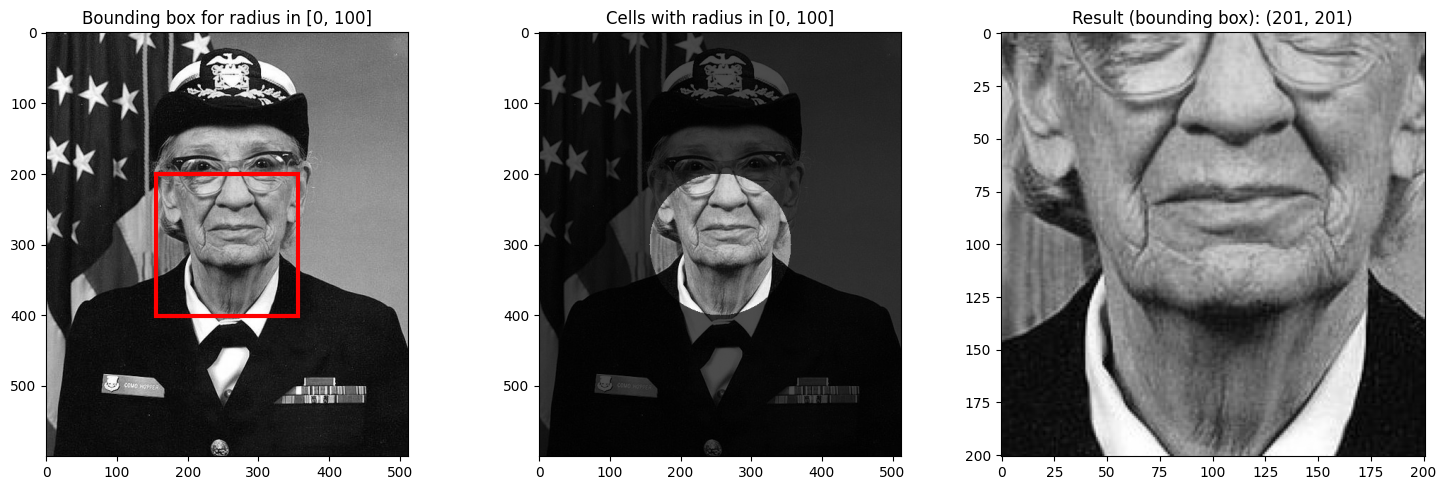

In [20]:
# Select center region
visualize_radial_selection(da_radial_indexed, 0, 100);

Notice how the bounding box for an annulus (ring) includes the entire rectangular region
around the ring, even though only the ring itself has radius values in the requested range.

This is the key insight about NDIndex's bounding box behavior: it returns the smallest
**rectangular** region that contains all matching cells, which may include non-matching cells.

## Summary: Bounding Box Behavior

Key points about NDIndex slicing with standard `ds.sel()`:

1. **Scalar selection** finds the single cell closest to the target value
2. **Slice selection** returns a **bounding box** containing all cells in range
3. The bounding box may include cells **outside** your requested range
4. Use `.where()` after selection to mask out values not in range
5. Use `slice(start, stop, step)` to subsample the innermost dimension

---

## Non-Rectangular Selection with `nd_sel`

The standard `ds.sel()` always returns a rectangular bounding box. But sometimes you want
**only** the cells actually in your requested range, with everything else masked out.

### Why a Helper Function?

xarray's custom index protocol (`Index.sel()`) returns an `IndexSelResult` which contains
indexers for each dimension. These can be slices, integer arrays, or boolean arrays.
While `IndexSelResult` *can* express non-rectangular selections via boolean arrays, it cannot:

- **Apply masks to data values** (setting cells to NaN while preserving the array shape)
- **Add new coordinates** (like a boolean membership indicator)

The index tells xarray *which indices* to select, but it doesn't have access to the actual
data values to modify them. That's why we need a helper function that:
1. First calls `ds.sel()` to get the bounding box (fast, O(log n))
2. Then applies the mask or adds the metadata coordinate as a post-processing step

### The `returns` Parameter

The `nd_sel` helper function provides non-rectangular selection with the `returns` parameter:

| Mode | Behavior | Creates Copy? |
|------|----------|---------------|
| `returns='slice'` | Standard bounding box (same as `ds.sel()`) | No (view) |
| `returns='mask'` | Bounding box with NaN outside the range | Yes (via `.where()`) |
| `returns='metadata'` | Bounding box + boolean coordinate showing membership | No (view) |

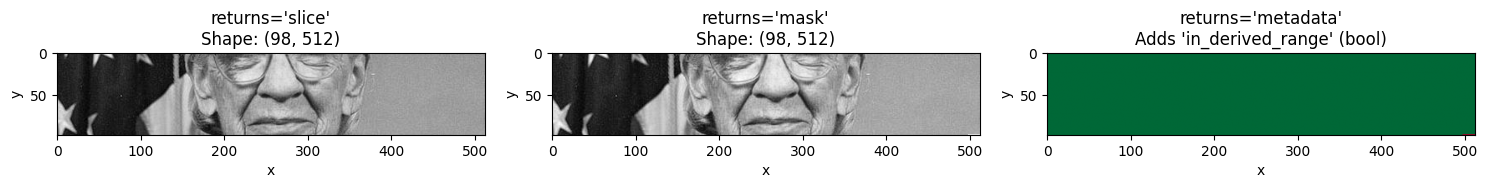

In [21]:
from linked_indices import nd_sel

# Compare the three return modes
start, stop = 100000, 150000

# Standard slice (bounding box)
result_slice = nd_sel(da_indexed, derived=slice(start, stop), returns="slice")

# Mask mode: NaN outside range
result_mask = nd_sel(da_indexed, derived=slice(start, stop), returns="mask")

# Metadata mode: boolean coordinate added
result_meta = nd_sel(da_indexed, derived=slice(start, stop), returns="metadata")

# All three have the same shape, but different content
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(result_slice.values, cmap="gray")
ax.set_title(f"returns='slice'\nShape: {result_slice.shape}")

ax = axes[1]
ax.imshow(result_mask.values, cmap="gray")
ax.set_title(f"returns='mask'\nShape: {result_mask.shape}")

ax = axes[2]
ax.imshow(result_meta.coords["in_derived_range"].values, cmap="RdYlGn", vmin=0, vmax=1)
ax.set_title("returns='metadata'\nAdds 'in_derived_range' (bool)")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()

### Radial Selection with Masking

The mask mode is especially useful with non-linear coordinates like radial distance.
With bounding box selection, an annulus (ring) returns a rectangle. With masking, 
you get just the ring.

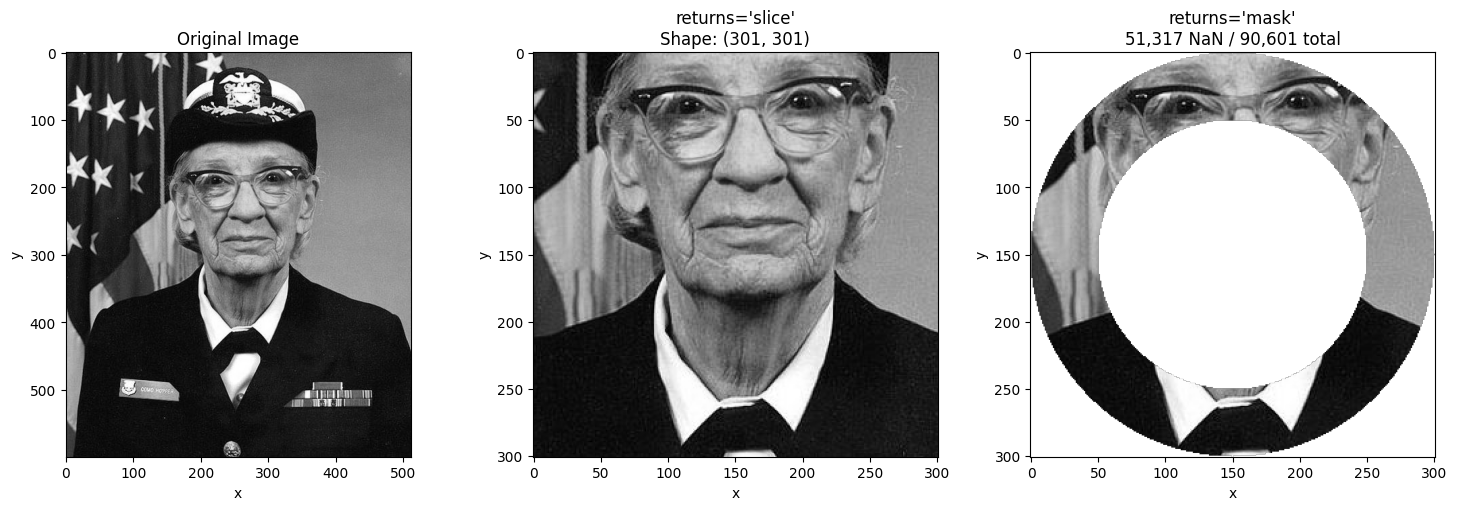

In [22]:
# Select a ring (annulus) with different return modes
r_start, r_stop = 100, 150

# Bounding box (standard)
ring_slice = nd_sel(da_radial_indexed, radius=slice(r_start, r_stop), returns="slice")

# Masked - only the ring, rest is NaN
ring_mask = nd_sel(da_radial_indexed, radius=slice(r_start, r_stop), returns="mask")

# Calculate NaN statistics for display
nan_count = np.isnan(ring_mask.values).sum()
total_count = ring_mask.size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(da_radial_indexed.values, cmap="gray")
ax.set_title("Original Image")

ax = axes[1]
ax.imshow(ring_slice.values, cmap="gray")
ax.set_title(f"returns='slice'\nShape: {ring_slice.shape}")

ax = axes[2]
ax.imshow(ring_mask.values, cmap="gray")
ax.set_title(f"returns='mask'\n{nan_count:,} NaN / {total_count:,} total")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()

### Combining with `method='nearest'`

You can combine `returns='mask'` with `method='nearest'` to snap boundaries to the 
nearest existing values before applying the mask.

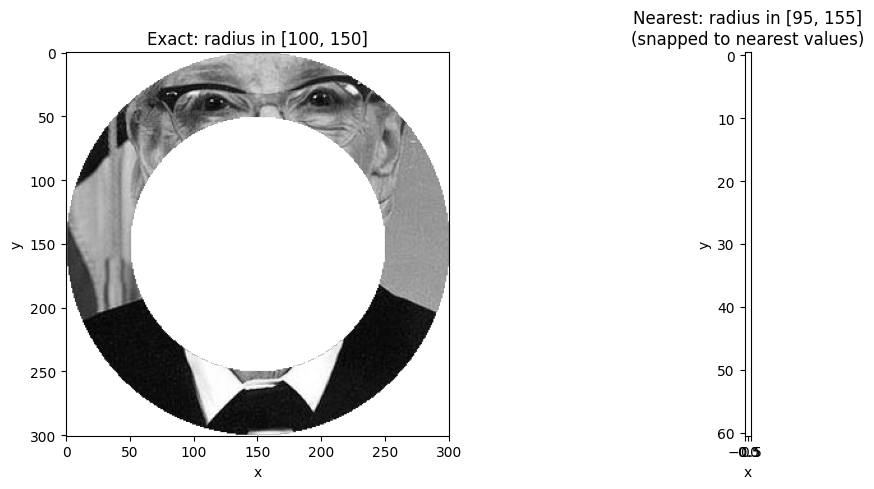

In [23]:
# Use nearest to snap boundaries
# Request radius 95-155, which snaps to nearest actual values
ring_nearest = nd_sel(
    da_radial_indexed,
    radius=slice(95, 155),  # Not exact values in the coordinate
    method="nearest",
    returns="mask",
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.imshow(ring_mask.values, cmap="gray")
ax.set_title("Exact: radius in [100, 150]")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(ring_nearest.values, cmap="gray")
ax.set_title("Nearest: radius in [95, 155]\n(snapped to nearest values)")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

### Using the Boolean Coordinate from `returns='metadata'`

The `returns='metadata'` mode adds a boolean coordinate that you can use for
custom filtering, statistics, or visualization.

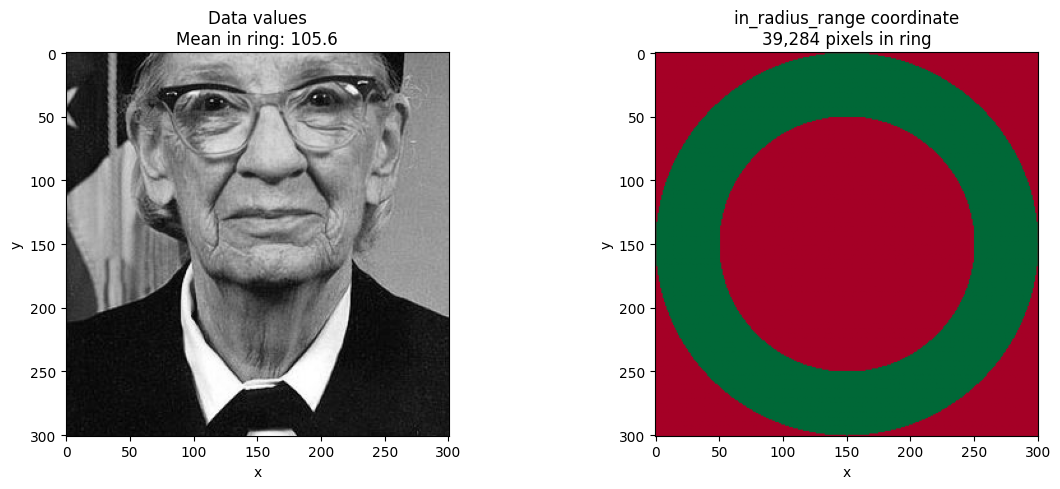

In [24]:
# Get result with membership metadata
result_with_meta = nd_sel(da_radial_indexed, radius=slice(100, 150), returns="metadata")

# Use the boolean coordinate for statistics
in_ring = result_with_meta.coords["in_radius_range"]
mean_in = result_with_meta.where(in_ring).mean().item()
mean_out = result_with_meta.where(~in_ring).mean().item()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.imshow(result_with_meta.values, cmap="gray")
ax.set_title(f"Data values\nMean in ring: {mean_in:.1f}")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(in_ring.values, cmap="RdYlGn", vmin=0, vmax=1)
ax.set_title(f"in_radius_range coordinate\n{in_ring.sum().item():,} pixels in ring")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

## Summary

The `nd_sel` helper function extends NDIndex selection with three return modes:

```python
from linked_indices import nd_sel

# Standard bounding box (same as ds.sel())
result = nd_sel(ds, coord=slice(start, stop), returns='slice')

# Mask values outside range with NaN
result = nd_sel(ds, coord=slice(start, stop), returns='mask')

# Add boolean coordinate for custom processing
result = nd_sel(ds, coord=slice(start, stop), returns='metadata')
```

Key points:
- All modes first compute the O(log n) bounding box, then apply post-processing
- `returns='mask'` creates a copy (via `.where()`)
- `returns='metadata'` preserves views, just adds a coordinate
- Combine with `method='nearest'` to snap boundaries to nearest values
- The helper is needed because xarray's `IndexSelResult` cannot apply masks to data values